# Cross-Release Performance Evaluation

In [2]:
# IMPORTS-------------------------
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
%matplotlib inline

from scipy import stats

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB, CategoricalNB
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#-------------

def weighted_failed_prediction_credit(y_true, y_predict):

    # normalize by size of Y to retain accurate metrics for different lenghts of Y
    size = y_true.shape[0]
    #print(y_true)
    #print(y_predict)
    correct_pred = y_true[ y_true == y_predict ]
    
    classified_as_popular = y_true[ y_predict == 2 ]
    #print(classified_as_popular)
    true_labels_of_misspredict_of_populars = classified_as_popular[ classified_as_popular != 2 ]
    #print(true_labels_of_misspredict_of_populars)
    p, ct = np.unique(true_labels_of_misspredict_of_populars, return_counts=True)
    fp_niche = dict(zip(p, ct))
    #print(fp_niche)
    fp_niche = fp_niche.get(1,0) / size
    
    # count of correctly predicted 'popular' instances
    p, ct = np.unique(correct_pred, return_counts=True)
    tp_popular = dict(zip(p, ct)).get(2,0) / size
    #print((tp_popular, fp_niche))
    #print()
    
    # by definition of the categories, niche comprises 40% [10,50]
    # This means the addressable area that can be classified as 'popular' is 50% (popular + niche area)
    return tp_popular + (1-(0.4+0.1))*fp_niche
#-------------

CONFIG__DATA_FILE_NAME_PLUNDER = 'plunder-RAD2MODE70-from2022-09-23-to2022-10-24'
CONFIG__DATA_FILE_NAME_SERAPH = 'seraph-RAD2MODE70-from2022-12-09-to2023-02-20'
CONFIG__DATA_FILE_NAME_LIGHTFALL = 'lightfall-RAD2MODE70-from2023-02-28-to2023-03-22'

In [3]:
df_plunder   = pd.read_csv('data/csv/'+CONFIG__DATA_FILE_NAME_PLUNDER + '.csv')
df_seraph    = pd.read_csv('data/csv/'+CONFIG__DATA_FILE_NAME_SERAPH + '.csv')
df_lightfall = pd.read_csv('data/csv/'+CONFIG__DATA_FILE_NAME_LIGHTFALL + '.csv')

In [4]:
df_seraph

,Name,Weapon Type,Archetype,Slot,WeaponID,Stability,Handling,Range,Aim Assistance,Airborne Effectiveness,...,Tap the Trigger present in any Column,Meganeura present in any Column,Timed Payload present in any Column,Ambitious Assassin present in any Column,Energy Transfer present in any Column,Slideways present in any Column,Eager Edge present in any Column,Usage Rate in Slot (%),Global Usage Rate (%),Popularity Category
0,Fioritura-59,Sidearm,Rapid-Fire Frame,Primary,2566006935,63,53,22,59,23,...,0,0,0,0,0,0,0,0.748663,0.422365,Niche
1,Roar of the Bear,Rocket Launcher,High-Impact Frame,Power,4009352833,57,65,-1,71,7,...,0,0,0,1,0,0,0,6.105513,0.690534,Popular
2,Eyasluna,Hand Cannon,Adaptive Frame,Primary,235827225,64,49,51,80,10,...,0,0,0,0,0,0,0,1.461676,0.824618,Popular
3,Fractethyst,Shotgun,Precision Frame,Special,3184681056,45,41,62,72,2,...,0,0,0,0,0,0,0,6.377233,2.058193,Popular
4,Bottom Dollar,Hand Cannon,Aggressive Frame,Primary,1046651176,28,31,60,66,10,...,0,0,0,0,0,0,0,0.724896,0.408957,Niche
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,Vertical Orbit QSm,Sidearm,Adaptive Frame,Primary,2812672356,64,47,33,79,12,...,0,0,0,0,0,0,0,0.011884,0.006704,Unpopular
515,One Earth,Hand Cannon,Adaptive Frame,Primary,3185293913,29,58,23,80,-1,...,0,0,0,0,0,0,0,0.011884,0.006704,Unpopular
516,Guseva-C,Hand Cannon,Aggressive Frame,Primary,1595336070,21,26,56,53,-1,...,0,0,0,0,0,0,0,0.011884,0.006704,Unpopular
517,Garden Progeny 1,Scout Rifle,High-Impact Frame,Primary,472169727,26,28,67,38,10,...,0,0,0,0,0,0,0,0.011884,0.006704,Unpopular


In [5]:
df_lightfall

,Name,Weapon Type,Archetype,Slot,WeaponID,Stability,Handling,Range,Aim Assistance,Airborne Effectiveness,...,Timed Payload present in any Column,Replenishing Aegis present in any Column,Ambitious Assassin present in any Column,Energy Transfer present in any Column,Slideways present in any Column,Destabilizing Rounds present in any Column,Eager Edge present in any Column,Usage Rate in Slot (%),Global Usage Rate (%),Popularity Category
0,Shayura's Wrath,Submachine Gun,Precision Frame,Primary,3682803680,44,27,59,60,25,...,0,0,0,0,0,0,0,1.049593,0.573148,Popular
1,Fractethyst,Shotgun,Precision Frame,Special,3184681056,45,41,62,72,2,...,0,0,0,0,0,0,0,4.150239,1.432870,Popular
2,Igneous Hammer,Hand Cannon,Aggressive Frame,Primary,2351180975,35,37,65,69,23,...,0,0,0,0,0,0,0,0.734715,0.401204,Popular
3,Gunnora's Axe,Shotgun,Pinpoint Slug Frame,Special,487361141,49,65,67,34,2,...,0,0,0,0,0,0,0,0.560282,0.193437,Niche
4,The Palindrome (Adept),Hand Cannon,Adaptive Frame,Primary,1481892490,58,50,50,79,21,...,0,0,0,0,0,0,0,2.138546,1.167789,Popular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,Emperor's Courtesy,Shotgun,Lightweight Frame,Special,3861448240,42,70,48,50,2,...,0,0,0,0,0,0,0,0.020751,0.007164,Unpopular
530,Misfit,Auto Rifle,Rapid-Fire Frame,Primary,819441402,53,41,28,76,10,...,0,0,0,0,1,0,0,0.013120,0.007164,Unpopular
531,Elegy-49,Sniper Rifle,Adaptive Frame,Special,1873270090,40,40,40,60,2,...,0,0,1,0,0,0,0,0.020751,0.007164,Unpopular
532,New City,Submachine Gun,Adaptive Frame,Primary,2414612776,43,52,43,45,12,...,0,0,0,0,0,0,0,0.013120,0.007164,Unpopular


In [6]:
new_in_seraph = set(df_seraph["Name"]) - set(df_plunder["Name"])
new_in_seraph = df_seraph.loc[df_seraph['Name'].isin(list(new_in_seraph))]
new_in_seraph

,Name,Weapon Type,Archetype,Slot,WeaponID,Stability,Handling,Range,Aim Assistance,Airborne Effectiveness,...,Tap the Trigger present in any Column,Meganeura present in any Column,Timed Payload present in any Column,Ambitious Assassin present in any Column,Energy Transfer present in any Column,Slideways present in any Column,Eager Edge present in any Column,Usage Rate in Slot (%),Global Usage Rate (%),Popularity Category
0,Fioritura-59,Sidearm,Rapid-Fire Frame,Primary,2566006935,63,53,22,59,23,...,0,0,0,0,0,0,0,0.748663,0.422365,Niche
12,Lodbrok-C,Auto Rifle,High-Impact Frame,Primary,2328531378,35,36,78,55,19,...,1,0,0,0,0,0,0,1.354724,0.764280,Popular
27,IKELOS_SR_v1.0.3,Sniper Rifle,Rapid-Fire Frame,Special,2302346155,39,67,30,73,4,...,0,0,0,0,0,0,0,0.519319,0.167605,Niche
29,Aurvandil FR6,Fusion Rifle,High-Impact Frame,Special,963710795,24,18,47,63,3,...,0,0,0,0,0,1,0,0.311591,0.100563,Niche
38,IKELOS_HC_v1.0.3,Hand Cannon,Precision Frame,Primary,1731355324,55,33,32,75,14,...,0,0,0,0,0,0,0,0.225787,0.127380,Niche
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,The Comedian (Adept),Shotgun,Aggressive Frame,Special,2443900757,23,30,28,38,3,...,0,0,0,0,0,0,0,0.020773,0.006704,Unpopular
514,Vertical Orbit QSm,Sidearm,Adaptive Frame,Primary,2812672356,64,47,33,79,12,...,0,0,0,0,0,0,0,0.011884,0.006704,Unpopular
515,One Earth,Hand Cannon,Adaptive Frame,Primary,3185293913,29,58,23,80,-1,...,0,0,0,0,0,0,0,0.011884,0.006704,Unpopular
516,Guseva-C,Hand Cannon,Aggressive Frame,Primary,1595336070,21,26,56,53,-1,...,0,0,0,0,0,0,0,0.011884,0.006704,Unpopular


In [7]:
new_in_lightfall = set(df_lightfall["Name"]) - set(df_seraph["Name"])
new_in_lightfall = df_lightfall.loc[df_lightfall['Name'].isin(list(new_in_lightfall))]
new_in_lightfall

,Name,Weapon Type,Archetype,Slot,WeaponID,Stability,Handling,Range,Aim Assistance,Airborne Effectiveness,...,Timed Payload present in any Column,Replenishing Aegis present in any Column,Ambitious Assassin present in any Column,Energy Transfer present in any Column,Slideways present in any Column,Destabilizing Rounds present in any Column,Eager Edge present in any Column,Usage Rate in Slot (%),Global Usage Rate (%),Popularity Category
15,The Immortal (Adept),Submachine Gun,Aggressive Frame,Primary,3193598749,25,58,50,39,25,...,0,0,0,0,0,0,0,13.251115,7.235994,Popular
19,The Immortal,Submachine Gun,Aggressive Frame,Primary,4039572196,25,58,50,39,25,...,0,0,0,0,0,0,0,2.728943,1.490185,Popular
21,Round Robin,Hand Cannon,Aggressive Frame,Primary,2034215657,20,24,56,58,14,...,0,0,0,0,0,0,0,3.660457,1.998854,Popular
25,Autumn Wind,Pulse Rifle,Rapid-Fire Frame,Primary,3110377595,47,25,32,80,15,...,0,0,0,0,1,0,0,3.266859,1.783923,Popular
38,Hand in Hand,Shotgun,Aggressive Frame,Special,664109750,20,26,18,33,3,...,0,0,0,0,0,0,0,0.705541,0.243588,Niche
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,Go Figure,Pulse Rifle,Aggressive Burst,Primary,4138174248,57,25,69,40,10,...,0,0,0,0,0,0,0,0.013120,0.007164,Unpopular
529,Emperor's Courtesy,Shotgun,Lightweight Frame,Special,3861448240,42,70,48,50,2,...,0,0,0,0,0,0,0,0.020751,0.007164,Unpopular
530,Misfit,Auto Rifle,Rapid-Fire Frame,Primary,819441402,53,41,28,76,10,...,0,0,0,0,1,0,0,0.013120,0.007164,Unpopular
531,Elegy-49,Sniper Rifle,Adaptive Frame,Special,1873270090,40,40,40,60,2,...,0,0,1,0,0,0,0,0.020751,0.007164,Unpopular


In [8]:
new_in_lightfall.columns

Index(['Name', 'Weapon Type', 'Archetype', 'Slot', 'WeaponID', 'Stability',
       'Handling', 'Range', 'Aim Assistance', 'Airborne Effectiveness',
       ...
       'Timed Payload present in any Column',
       'Replenishing Aegis present in any Column',
       'Ambitious Assassin present in any Column',
       'Energy Transfer present in any Column',
       'Slideways present in any Column',
       'Destabilizing Rounds present in any Column',
       'Eager Edge present in any Column', 'Usage Rate in Slot (%)',
       'Global Usage Rate (%)', 'Popularity Category'],
      dtype='object', length=185)

## Conversion utilities

In [9]:
def retrofit(past_df, present_df, instance_l):
    # Temporary dataframe to retrofit
    tmpdf = past_df.copy()[:len(instance_l)]

    for i in range(instance_l.shape[0]):
        for col in present_df.columns:
            # For each new instance, insert the features that are present in the past df
            if col not in past_df.columns:
                continue 
            v = (instance_l.iloc[i])[col]
            tmpdf.at[i, col] = v
            
    return tmpdf

In [10]:
retrofit(df_seraph, df_lightfall, new_in_lightfall)

,Name,Weapon Type,Archetype,Slot,WeaponID,Stability,Handling,Range,Aim Assistance,Airborne Effectiveness,...,Tap the Trigger present in any Column,Meganeura present in any Column,Timed Payload present in any Column,Ambitious Assassin present in any Column,Energy Transfer present in any Column,Slideways present in any Column,Eager Edge present in any Column,Usage Rate in Slot (%),Global Usage Rate (%),Popularity Category
0,The Immortal (Adept),Submachine Gun,Aggressive Frame,Primary,3193598749,25,58,50,39,25,...,1,0,0,0,0,0,0,13.251115,7.235994,Popular
1,The Immortal,Submachine Gun,Aggressive Frame,Primary,4039572196,25,58,50,39,25,...,1,0,0,0,0,0,0,2.728943,1.490185,Popular
2,Round Robin,Hand Cannon,Aggressive Frame,Primary,2034215657,20,24,56,58,14,...,0,0,0,0,0,0,0,3.660457,1.998854,Popular
3,Autumn Wind,Pulse Rifle,Rapid-Fire Frame,Primary,3110377595,47,25,32,80,15,...,0,0,0,0,0,1,0,3.266859,1.783923,Popular
4,Hand in Hand,Shotgun,Aggressive Frame,Special,664109750,20,26,18,33,3,...,0,0,0,0,0,0,0,0.705541,0.243588,Niche
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Go Figure,Pulse Rifle,Aggressive Burst,Primary,4138174248,57,25,69,40,10,...,0,0,0,0,0,0,0,0.013120,0.007164,Unpopular
73,Emperor's Courtesy,Shotgun,Lightweight Frame,Special,3861448240,42,70,48,50,2,...,0,0,0,0,0,0,0,0.020751,0.007164,Unpopular
74,Misfit,Auto Rifle,Rapid-Fire Frame,Primary,819441402,53,41,28,76,10,...,1,0,0,0,0,1,0,0.013120,0.007164,Unpopular
75,Elegy-49,Sniper Rifle,Adaptive Frame,Special,1873270090,40,40,40,60,2,...,0,0,0,1,0,0,0,0.020751,0.007164,Unpopular


## Visualization function

## Performance transfer to Seraph

In [11]:
name = []
models = []
for fname in glob.glob('models/plunder/*.d2model'):
    name.append(fname[fname.rfind('/')+1:fname.rfind('.')])
    
    with open(fname, "rb") as f:
        models.append(pickle.load(f))
        
plunder_models = {n : m for n, m in zip(name, models)}
#plunder_models

/var/mobile/Containers/Data/Application/5369ACBF-FD78-42BF-B278-3DCB44CAB79D/Library/Application Support/com.rationalmatter.junoapp/python-home/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/var/mobile/Containers/Data/Application/5369ACBF-FD78-42BF-B278-3DCB44CAB79D/Library/Application Support/com.rationalmatter.junoapp/python-home/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limita

## Preprocess retrofitted datasets

In [12]:
retro_new_in_seraph = retrofit(df_plunder, df_seraph, new_in_seraph)
retro_new_in_lightfall = retrofit(df_plunder, df_lightfall, new_in_lightfall)
retro_seraph_all = retrofit(df_plunder, df_seraph, df_seraph)
retro_lightfall_all = retrofit(df_plunder, df_lightfall, df_lightfall)

In [13]:
def preprocess_and_encode(instance_df, origin_df):
    feat_to_drop = ["Name", "WeaponID", "Ocurrences", "Global Usage Rate (%)", "Usage Rate in Slot (%)"]

    df_2 = instance_df.drop(feat_to_drop, axis='columns')

    # There should be no empty columns
    #empty_columns = (df_2.sum(axis=0)) == 0
    #df_2 = df_2.loc[:, ~empty_columns]


    lc = LabelEncoder()

    feat_to_encode = ["Slot", "Archetype", "Weapon Type"]
    for f in feat_to_encode:
        # the encoder NEEDS to be fitted on the same data
        lc.fit(origin_df[f])
        df_2[f] = lc.transform(df_2[f])
    
    conv = []
    for i in range(df_2.shape[0]):
        cat = df_2.iloc[i]['Popularity Category']
        if cat == 'Niche':
            conv.append(1)
        elif cat == 'Popular':
            conv.append(2)
        else: # unpopular
            conv.append(0)
    df_2['Popularity Category'] = conv

    arr = df_2.to_numpy()
    X = arr[:, :-1]
    Y = arr[:, -1].astype(int)
    
    return X,Y

In [14]:
X_seraph_new, Y_seraph_new = preprocess_and_encode(retro_new_in_seraph, df_seraph)
X_seraph_all, Y_seraph_all = preprocess_and_encode(retro_seraph_all, df_seraph)
X_seraph_all, Y_seraph_all

(array([[12., 14.,  1., ...,  0.,  0.,  0.],
        [ 9.,  7.,  0., ...,  0.,  0.,  0.],
        [ 5.,  0.,  1., ...,  0.,  0.,  0.],
        ...,
        [ 5.,  3.,  1., ...,  0.,  0.,  0.],
        [10.,  7.,  1., ...,  0.,  0.,  0.],
        [13., 14.,  2., ...,  0.,  0.,  0.]]),
 array([1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1,
        2, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 0, 0,
        1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 0,
        1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0,
        1, 2, 2, 2, 1, 2, 0, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1,
        0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 0, 0, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 2, 2, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,

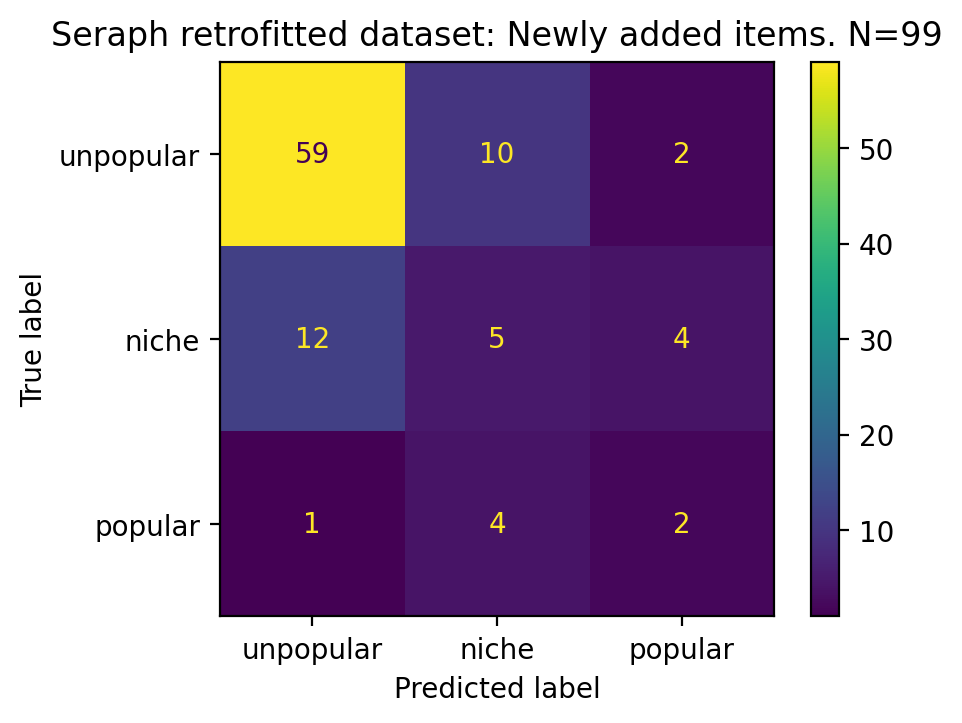

0.04040404040404041


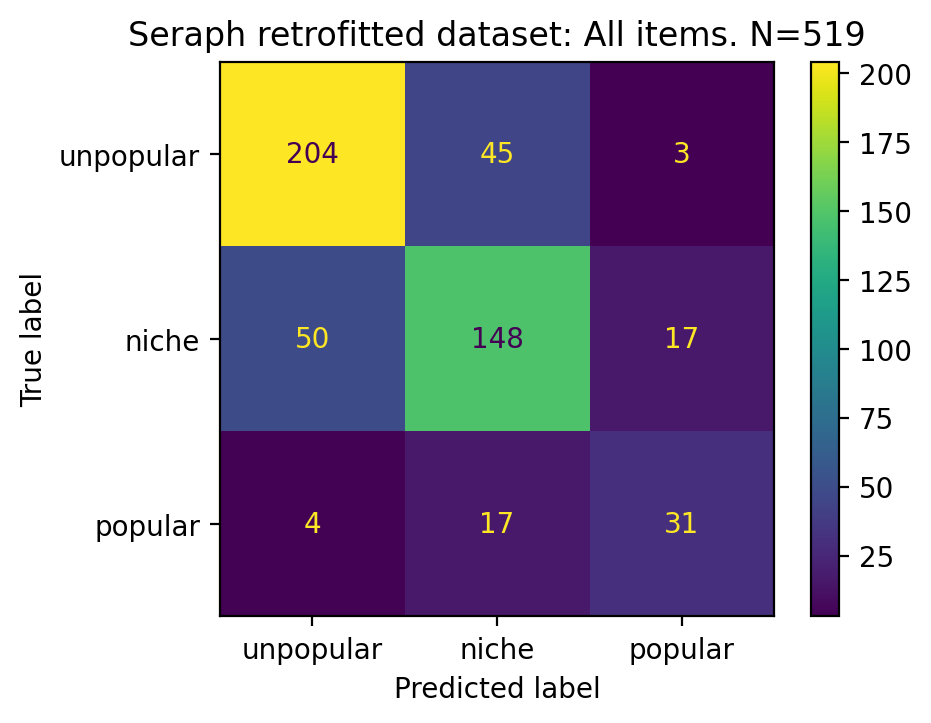

0.07610789980732177


In [16]:
Y_predict = plunder_models['plunder-svm'].predict(X_seraph_new)
m = confusion_matrix(Y_seraph_new, Y_predict)
ConfusionMatrixDisplay(confusion_matrix=m, display_labels=["unpopular", 'niche', "popular"]).plot()
plt.title(f"Seraph retrofitted dataset: Newly added items. N={Y_seraph_new.shape[0]}")
plt.show()
print(weighted_failed_prediction_credit(Y_seraph_new, Y_predict))


Y_predict = plunder_models['plunder-svm'].predict(X_seraph_all)
m = confusion_matrix(Y_seraph_all, Y_predict)
ConfusionMatrixDisplay(confusion_matrix=m, display_labels=["unpopular", 'niche', "popular"]).plot()
plt.title(f"Seraph retrofitted dataset: All items. N={Y_seraph_all.shape[0]}")
plt.show()
print(weighted_failed_prediction_credit(Y_seraph_all, Y_predict))

In [ ]:
X_lightfall_new, Y_lightfall_new = preprocess_and_encode(retro_new_in_lightfall, df_lightfall)
X_lightfall_all, Y_lightfall_all = preprocess_and_encode(retro_lightfall_all, df_lightfall)
X_lightfall_all, Y_lightfall_all

In [ ]:
Y_predict = plunder_models['plunder-svc'].predict(X_lightfall_new)
m = confusion_matrix(Y_lightfall_new, Y_predict)
ConfusionMatrixDisplay(confusion_matrix=m, display_labels=["unpopular", 'niche', "popular"]).plot()
plt.title(f"Lightfall retrofitted dataset: Newly added items. N={Y_lightfall_new.shape[0]}")
plt.show()
print(weighted_failed_prediction_credit(Y_lightfall_new, Y_predict))


Y_predict = plunder_models['plunder-svc'].predict(X_lightfall_all)
m = confusion_matrix(Y_lightfall_all, Y_predict)
ConfusionMatrixDisplay(confusion_matrix=m, display_labels=["unpopular", 'niche', "popular"]).plot()
plt.title(f"Lightfall retrofitted dataset: All items. N={Y_lightfall_all.shape[0]}")
plt.show()
print(weighted_failed_prediction_credit(Y_lightfall_all, Y_predict))

In [ ]:
feature_names = df_plunder.copy().drop(["Name", "WeaponID", "Ocurrences", "Global Usage Rate (%)", "Usage Rate in Slot (%)"], axis='columns').columns
print(list(feature_names))

plt.figure(figsize=(30,30), dpi=300)
plt.rcParams.update({'font.size' : 50})
plot_tree(plunder_models['plunder-bdt'],feature_names=feature_names, class_names=['Unpopular', 'Niche', 'Popular'], max_depth=4, impurity=False)
plt.savefig('performance/lol.png')